### Import Libraries

In [1]:
import utils
utils.set_seed(utils.seed)

import dataloaders

100%|██████████| 7884/7884 [00:26<00:00, 297.90it/s]


In [2]:
import  nets
import  deeplearning
import  torch
import  torch.nn                as  nn          # basic building block for neural networks
import  matplotlib.pyplot       as  plt         # for plotting
import  numpy                   as  np            
from    tqdm                    import  tqdm
from    sklearn.metrics         import  accuracy_score                          

In [3]:
model = nets.VisionTransformer(
                                    img_size        =   utils.input_image_size,
                                    patch_size      =   utils.patch_size,
                                    in_chans        =   utils.in_chanel,
                                    n_classes       =   utils.num_classes,  
                                    embed_dim       =   utils.embed_dim,
                                    depth           =   utils.depth,
                                    n_heads         =   utils.n_heads,
                                    mlp_ratio       =   4.0,
                                    qkv_bias        =   True,
                                    p               =   utils.p,
                                    attn_p          =   utils.attention_p
                                ).to(utils.device)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=utils.learning_rate,
                              betas=(0.9, 0.999),
                              eps=1e-08,
                              weight_decay=utils.weight_decay,)
criterion = nn.BCELoss() 


In [9]:
# immg = next(iter(dataloaders.train_loader))[0][0]

# Plot tensors in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, batch in enumerate(dataloaders.train_loader):
    for j, tensor in enumerate(batch):
        if i * 16 + j < 16:
            # Convert tensor to NumPy array for plotting
            image_array = tensor.permute(1, 2, 0).cpu().numpy()  # Assuming CHW format, adjust if needed
            axes[i, j].imshow(image_array)
            axes[i, j].axis('off')

plt.show()


### Train Model

In [10]:
model, optimizer, report = deeplearning.train(
                                                test_ealuate    = False,
                                                train_loader    = dataloaders.train_loader,
                                                val_loader      = dataloaders.val_loader,
                                                tets_loader     = None,
                                                model       = model,
                                                model_name  = f"n_heads={utils.n_heads}_depth={utils.depth}_learning_rate={utils.learning_rate}_weight_decay={utils.weight_decay}_embed_dim={utils.embed_dim}",
                                                
                                                epochs          = utils.num_epochs,#utils.num_epochs,
                                                device          = utils.device,
                                                load_saved_model= False,
                                                ckpt_save_freq  = utils.ckpt_save_freq,
                                                ckpt_save_path  = r'./model/checkpoint',
                                                ckpt_path       = r'./model/',
                                                report_path     = r'./model/',

                                                optimizer       = optimizer,
                                                criterion       = criterion,

                                                lr_schedulerr_setting =60,
                                                lr_schedulerr  = None,
                                                validation_threshold = 0.98
                                                )


100%|██████████| 15/15 [35:16<00:00, 141.09s/it]


In [11]:
model .load_state_dict(torch.load(r'.\model\n_heads=12_depth=1_learning_rate=0.001_weight_decay=0.03_embed_dim=192_valid_acc 0.9906531531531532.pt'))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(7, 7), stride=(7, 7))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (head): Sequential(
    (0): Linear(in_features=192, out_features=38

In [12]:
test_loss = 0.0
y_true_test = []
y_pred_test = []
test_accuracy = []
test_losses = []

device = 'cuda'
model = model.cuda()
with torch.inference_mode():
        for batch in tqdm(dataloaders.test_loader, desc=f"testing dataset", leave=False):
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_hat = model(x).squeeze(1)
                

                # Ensure that the data type (dtype) matches the device
                y, y_hat = y.to(device), y_hat.to(device, dtype=torch.float)

                loss = criterion(y_hat.float(), y.float())

                test_loss += loss.detach().cpu().item() / len(dataloaders.test_loader)

                # Calculate testing accuracy
                y_true_test.extend(y.detach().cpu().numpy())
                y_pred_test.extend(torch.round(y_hat).detach().cpu().numpy())

        test_acc = accuracy_score(y_true_test, y_pred_test)
        test_accuracy.append(test_acc)
        test_losses.append(test_loss)    

print(f"Test Accuracy = {test_accuracy}")
print(f"Test Loss = {test_losses}")

Test Accuracy = [0.9603040540540541]
Test Loss = [0.2320260503692152]


### Show Sample Images

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Define a dictionary to map class indices to class names
# class_names = dataloaders.dataset.classes
# class_to_idx = dataloaders.dataset.class_to_idx
# idx_to_class = {v: k for k, v in class_to_idx.items()}

# # Function to show random images with labels
# def show_random_images(loader, num_images=4):
#     data_iter = iter(loader)
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

#     for i in range(num_images):
#         images, labels = next(data_iter)
#         ax = axes[i]

#         # Choose a random image from the batch
#         idx = np.random.randint(0, len(images))
#         image = images[idx].numpy().transpose((1, 2, 0))
#         label = class_names[labels[idx].item()]

#         ax.imshow(image)
#         ax.set_title(label)
#         ax.axis('off')

#     plt.show()

# # Show random images from the training dataset
# show_random_images(dataloaders.train_loader)

### Test Model

In [ ]:
model = nets.VisionTransformer(
                                    img_size=224,
                                    patch_size=7,
                                    in_chans=3,
                                    n_classes=2,  # Assuming 2 classes (Healthy and Damaged)
                                    embed_dim=384//2,
                                    depth=1,
                                    n_heads=8,
                                    mlp_ratio=4.0,
                                    qkv_bias=True,
                                    p=0.1,
                                    attn_p=0.1
                                )
model .load_state_dict(torch.load(r'.\model\ViT_L1_learning_rate=0.001_weight_decay=0.03_valid_acc 1.0.pt'))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(7, 7), stride=(7, 7))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (head): Sequential(
    (0): Linear(in_features=192, out_features=38

In [ ]:
vv = torch.zeros(size=[1,3,224,224])
vv[0,:,28:28*2,:]=1

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Create a sample PyTorch tensor (replace this with your own tensor)
tensor_data = torch.rand(1, 256, 256)  # Assuming a 3-channel image with dimensions 256x256

# Convert PyTorch tensor to a PIL Image
tensor_to_pil = transforms.ToPILImage()
# image = tensor_to_pil((vv[0]))
image = tensor_to_pil(model.patch_embed(vv))


# Save the image (optional)
image.save("output_image.png")

# Display the image (optional)
image.show()


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def save_tensor_to_svg(tensor, file_path, cmap='gray'):
    """
    Save a 2D tensor as an SVG file using matplotlib.

    Parameters:
    - tensor (torch.Tensor): Input 2D tensor
    - file_path (str): Path to save the SVG file
    - cmap (str, optional): Colormap for the plot. Default is 'viridis'.
    """
    # Convert tensor to NumPy array
    array_data = tensor.detach().cpu().numpy() if torch.is_tensor(tensor) else tensor

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the array as an image with the specified colormap
    im = ax.imshow(array_data, cmap=cmap)

    # # Add colorbar for better interpretation (optional)
    # cbar = plt.colorbar(im)
    # # Hide colorbar if show_colorbar is False
    # if not show_colorbar:
    #     plt.colorbar(im).remove()
    
    # Hide the legend
    ax.legend().set_visible(False)

    # Hide axis numbers
    ax.set_xticks([])
    ax.set_yticks([])

    

    # Save the figure as an SVG file
    plt.savefig(file_path, format='pdf', dpi=1600)

    # Close the figure to free up resources
    plt.close()

# Example usage:
# Create a random 2D tensor (replace this with your own tensor)
random_tensor = torch.rand((10, 10))

# Save the tensor as an SVG file
save_tensor_to_svg(model.patch_embed(vv)[0], 'after patch.pdf')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


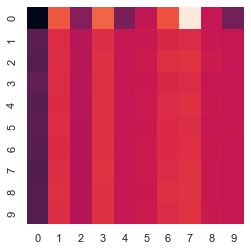

In [ ]:
import seaborn              as      sns; sns.set()
import  matplotlib.pyplot   as      plt
from    matplotlib          import  font_manager as fm, rcParams

model(next(iter(dataloaders.test_loader))[0]).shape

Heatmap = sns.heatmap(model.blocks[0].attn.attn[0,0,:10,:10].detach().numpy(),
                    annot=False,
                    square=True,
                    # xticklabels=tokens,
                    # yticklabels=tokens,
                    cbar=False,
                    )

In [ ]:
model = nets.VisionTransformer(
                                    img_size=224,
                                    patch_size=7,
                                    in_chans=3,
                                    n_classes=2,  # Assuming 2 classes (Healthy and Damaged)
                                    embed_dim=384,
                                    depth=1,
                                    n_heads=8,
                                    mlp_ratio=4.0,
                                    qkv_bias=True,
                                    p=0.1,
                                    attn_p=0.1
                                )
model .load_state_dict(torch.load(r'.\model\ViT_L1_learning_rate=0.001_weight_decay=0.03_valid_acc 1.0.pt'))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(7, 7), stride=(7, 7))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Sequential(
    (0): Linear(in_features=384, out_features

### Plot Loss & Accuracy

In [ ]:
epochs = range(1, num_epochs + 1)

# Plot the training and testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
#plt.plot(epochs, test_accuracy, label='Testing Accuracy')
plt.xticks(epochs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
#plt.plot(epochs, test_losses, label='Testing Loss')
plt.xticks(epochs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
print(f"y_hat is: {y_hat}")
print(f"y is: {y}")
print(f"y_hat shape: {y_hat.shape}")
print(f"y shape: {y.shape}")

In [ ]:
from torchsummary import summary
input_size=(3,224,224)
summary(model,input_size = input_size)